In [2]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import statistics as st
import seaborn as sns
import datetime 
from geopy import distance
import folium
from folium.plugins import MarkerCluster
from folium.features import GeoJsonTooltip
from branca.colormap import LinearColormap
from collections import Counter
import json
from shapely.geometry import Point
import geopandas as gpd
from shapely.geometry import shape

In [3]:
data_types = {
    "rideable_type": "category", 
    "start_station_name": "category", 
    "end_station_name": "category", 
    "member_casual":"category",
    # "ride_id":"uint32",
    "time_of_day":"category",
    "trip_type":"category"}


In [ ]:
rides_maryland = pd.read_csv("cabi_maryland.csv", dtype = data_types, parse_dates= ["started_at", "ended_at"], low_memory=False)


In [5]:
with open ("Maryland_Physical_Boundaries_-_County_Boundaries_(Detailed).geojson") as i:
    maryland = json.loads(i.read())

features = maryland["features"]

#GDF
maryland_gdf = gpd.GeoDataFrame(
    pd.DataFrame([feature['properties'] for feature in features]),  # Extract properties as attributes
    geometry=[shape(feature['geometry']) for feature in features],  # Convert geometries
    crs="EPSG:4326")

# join gdf and filter maryland rides

In [ ]:
# # Create a GeoDataFrame for the start stations
# geometry = [Point(xy) for xy in zip(rides_maryland['start_lng'], rides_maryland['start_lat'])]
# bikes_gdf = gpd.GeoDataFrame(rides_maryland, geometry=geometry, crs="EPSG:4326")

# # # Perform spatial join with the maryland gdf
# bikes_maryland_join = gpd.sjoin(bikes_gdf, maryland_gdf, how="left", predicate="within")

In [ ]:
# rides_maryland = bikes_maryland_join.dropna(subset="COUNTY")


In [ ]:
# rides_maryland = rides_maryland.copy()

In [ ]:
# rides_maryland['year'] = rides_maryland['started_at'].dt.year
# rides_maryland['dow'] = rides_maryland['started_at'].dt.dayofweek
# rides_maryland["weekday"] = rides_maryland["started_at"].dt.day_name()

In [ ]:
# rides_maryland = rides_maryland.drop(columns= ['index_right','OBJECTID','DISTRICT', 'COUNTY_FIP', 'COUNTYNUM','CREATION_D', 'LAST_UPDAT'])

In [14]:
# # Count rides per county
rides_per_county = rides_maryland.groupby("COUNTY").size().reset_index(name="ride_count")  
rides_per_county

,COUNTY,ride_count
0,Montgomery,168967
1,Prince George's,74195


In [ ]:
# # Convert 'weekday' to a categorical type with the correct order
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
# rides_maryland["weekday"] = pd.Categorical(rides_maryland["weekday"], categories=weekday_order, ordered=True)


In [ ]:
# rides_maryland.to_csv("cabi_maryland.csv", index=False)

# filtering per year

In [31]:
year_2021= rides_maryland[rides_maryland["year"]==2021]
year_2022= rides_maryland[rides_maryland["year"]==2022]
rides_maryland_2023= rides_maryland[rides_maryland["year"]==2023]

In [32]:
rides_maryland["year"].value_counts()

year
2023    98071
2021    72587
2022    72504
Name: count, dtype: int64

# filtering unique stations (classic and docked ebikes) from undocked e-bikes 

In [33]:
# unique_station_coordinates.groupby("start_station_name")["start_lat"].mean()
avg_lat_per_station = rides_maryland.groupby("start_station_name", as_index=False, observed=False)["start_lat"].mean()
avg_lng_per_station = rides_maryland.groupby("start_station_name", as_index=False, observed = False)["start_lng"].mean()

maryland_unique_bike_stations = avg_lat_per_station.merge(avg_lng_per_station)
maryland_unique_bike_stations = maryland_unique_bike_stations.dropna(subset="start_lat")
maryland_unique_bike_stations

,start_station_name,start_lat,start_lng
5,10th & Monroe St NE,38.973495,-77.020706
8,10th & U St NW,38.983053,-76.998549
14,11th & C St SE,39.000126,-77.079726
15,11th & Clifton St NW,39.012635,-77.066359
21,11th & O St NW,39.012635,-77.066359
...,...,...,...
850,Wisconsin Ave & Ingomar St NW,39.012635,-77.066359
851,Wisconsin Ave & Newark St NW,38.931240,-76.951919
853,Wisconsin Ave & Rodman St NW,38.989793,-77.028654
855,Woodglen Dr & Executive Blvd,39.043182,-77.113494


In [34]:
rides_maryland_2023["rideable_type"].value_counts()

rideable_type
electric_bike    48641
classic_bike     46467
docked_bike       2963
Name: count, dtype: int64

In [40]:
undocked_bikes = rides_maryland_2023[rides_maryland_2023["rideable_type"] == "electric_bike" ]

In [56]:
undocked_bikes["started_at"].dt.date.nunique()

365

In [144]:
# Count rides per weekday
rides_per_day = undocked_bikes["weekday"].value_counts().sort_index()

# Calculate average rides per weekday
# nunique() gives the number of unique dates in the dataset.
# Count how many times each weekday appears in the dataset
unique_dates = undocked_bikes["started_at"].dt.date.unique()  # Get all unique dates
dates_df = pd.DataFrame({"date": unique_dates})  # Convert to DataFrame
dates_df["weekday"] = pd.to_datetime(dates_df["date"]).dt.day_name()  # Extract weekday
dates_df["weekday"] = pd.Categorical(dates_df["weekday"], categories=weekday_order, ordered=True)
days_per_weekday = dates_df["weekday"].value_counts().sort_index()


In [145]:
days_per_weekday

weekday
Monday       52
Tuesday      52
Wednesday    52
Thursday     52
Friday       52
Saturday     52
Sunday       53
Name: count, dtype: int64

In [146]:
# Can also just divide by number of weeks in a year (52) 
average_rides = rides_per_day / days_per_weekday # weeks in a year / undocked_bikes["started_at"].dt.date.nunique()
print("Average undocked rides in Maryland for each day of the week in 2023",average_rides)

Average undocked rides in Maryland for each day of the week in 2023 weekday
Monday       126.750000
Tuesday      138.057692
Wednesday    136.307692
Thursday     136.961538
Friday       134.192308
Saturday     133.769231
Sunday       126.924528
Name: count, dtype: float64


<Axes: xlabel='weekday'>

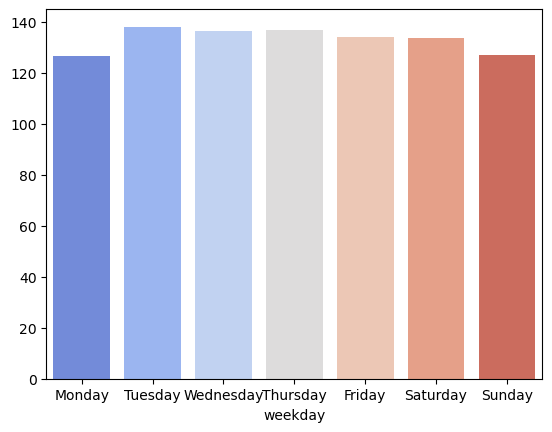

In [147]:
sns.barplot(x=average_rides.index, y=average_rides.values, palette="coolwarm", hue=average_rides.index)

undocked bikes shows rides, not stations. can think of a timelapse per hour to see how the bikes are placed at a given time. Mapping all the undocled ebikes in a year at once will give the impression there are lot more in circulation than they actually are

# choosing a Random day to check the bikes distribution on a map


In [149]:
# sampling a random date
random_date = np.random.choice(undocked_bikes["started_at"].dt.date.unique())
print(f"Randomly selected date: {random_date}")

# Filter dataset for the chosen date
random_day = undocked_bikes[undocked_bikes["started_at"].dt.date == pd.to_datetime(random_date).date()]

Randomly selected date: 2023-05-16


In [150]:
#REVIEW - should i consider all ebikes as being dockless? 
# half of them have info on start station, which could indicate that they were left near a station, but not docked

# keeping only rides without bike stations to account for undocked bikes
# random_day[random_day["start_station_name"].isna()]
random_day

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,member_casual,start_lat,...,end_hour,trip_duration_minutes,time_of_day,geometry,COUNTY,Shape_Length,Shape_Area,year,dow,weekday
7519139,7519140,electric_bike,2023-05-16 00:26:35,2023-05-16 00:30:23,West Hyattsville Metro,32418,NaN,32418,casual,38.955336,...,0,4.0,night,POINT (-76.96806 38.95534),Prince George's,3.427406,0.130280,2023,1,Tuesday
7519173,7519174,electric_bike,2023-05-16 00:53:01,2023-05-16 01:10:02,Silver Spring Transit Center - Top Level,32034,10th St & Spring Rd NW,31426,member,38.994032,...,1,17.0,night,POINT (-77.03042 38.99403),Montgomery,4.104648,0.134082,2023,1,Tuesday
7519174,7519175,electric_bike,2023-05-16 00:53:07,2023-05-16 01:08:47,Silver Spring Transit Center - Top Level,32034,NaN,31229,member,38.994036,...,1,16.0,night,POINT (-77.03042 38.99404),Montgomery,4.104648,0.134082,2023,1,Tuesday
7519239,7519240,electric_bike,2023-05-16 02:26:18,2023-05-16 02:26:49,NaN,31806,NaN,31806,casual,38.850000,...,2,1.0,night,POINT (-76.96 38.85),Prince George's,3.427406,0.130280,2023,1,Tuesday
7519241,7519242,electric_bike,2023-05-16 02:27:52,2023-05-16 03:07:34,NaN,31806,NaN,31806,casual,38.850000,...,3,40.0,night,POINT (-76.96 38.85),Prince George's,3.427406,0.130280,2023,1,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7532357,7532358,electric_bike,2023-05-16 22:46:06,2023-05-16 22:51:47,NaN,31806,Anacostia Library,31804,casual,38.850000,...,22,6.0,night,POINT (-76.96 38.85),Prince George's,3.427406,0.130280,2023,1,Tuesday
7532547,7532548,electric_bike,2023-05-16 23:27:14,2023-05-17 00:14:20,Citadel Ave & McGrath Blvd,32076,NaN,32078,casual,39.048992,...,0,47.0,night,POINT (-77.10937 39.04899),Montgomery,4.104648,0.134082,2023,1,Tuesday
7532550,7532551,electric_bike,2023-05-16 23:29:11,2023-05-16 23:38:54,Silver Spring Transit Center - Top Level,32034,NaN,31515,member,38.994066,...,23,10.0,night,POINT (-77.03044 38.99407),Montgomery,4.104648,0.134082,2023,1,Tuesday
7532552,7532553,electric_bike,2023-05-16 23:29:39,2023-05-16 23:48:50,Battery Ln & Trolley Trail,32027,Battery Ln & Trolley Trail,32027,casual,38.992402,...,23,19.0,night,POINT (-77.10015 38.9924),Montgomery,4.104648,0.134082,2023,1,Tuesday


In [157]:
random_day_gdf = random_day.copy()

In [161]:
random_day_gdf = random_day_gdf.drop(columns=["started_at", "ended_at"])

In [180]:
avg_lat = random_day["start_lat"].mean()
avg_lng = random_day["start_lng"].mean()

maryland_map= folium.Map(location=[avg_lat, avg_lng],   
                zoom_start=12,              
                max_zoom=26,               
                min_zoom=2)  

# marker_cluster = MarkerCluster(name= "E-bikes").add_to(maryland_map)

In [181]:
l1 = folium.GeoJson(
    random_day_gdf,  
    overlay= True, 
    control = True,
    show = True,
    name= "E-bikes",
    marker=folium.CircleMarker(radius=4, fill_color="white", fill_opacity=1, color="black", weight=1),
    tooltip=folium.GeoJsonTooltip(fields=["start_station_name"],
                                  aliases=["Station: "]),
    popup=folium.GeoJsonPopup(fields=["start_station_name"]),
    highlight_function=lambda x: {"fillOpacity": 0.8},
    zoom_on_click=False,
).add_to(maryland_map)

In [182]:
maryland_map